In [5]:
filepathX = "/eyecolor/data/Train.csv"
filepathY = "/eyecolor/data/TrainLabels.csv"


In [48]:
import numpy as np
input_x = np.genfromtxt(filepathX, delimiter=',')
input_x

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 1., 1.],
       [2., 0., 0., ..., 0., 2., 2.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [49]:
# Read x input and process it with column names
x = np.transpose(input_x)
x
col_names = ['col_'+str(i) for i in range(x.shape[1])]
print(len(col_names))
df_raw = pd.DataFrame(x, columns= col_names)
df_raw.shape

100000


(100, 100000)

(array([20,  0, 20,  0,  0, 20,  0, 20,  0, 20]), array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1146ee9b0>]],
      dtype=object)

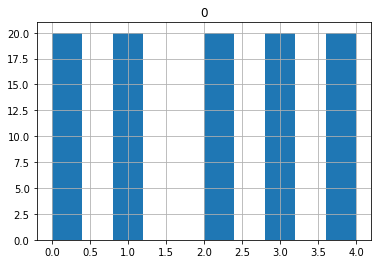

In [47]:
# Read y input
y = np.genfromtxt(filepathY,delimiter=',')
y
print(np.histogram(y))

target_y = pd.DataFrame(y)
target_y.hist()



In [54]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
n_valid = 30
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_raw, n_trn)
y_train, y_valid = split_vals(target_y, n_trn)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((70, 100000), (30, 100000), (70, 1), (30, 1))

(array([6, 0, 6, 0, 0, 6, 0, 6, 0, 6]), array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]))


(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1144bfd68>]],
       dtype=object), 30)

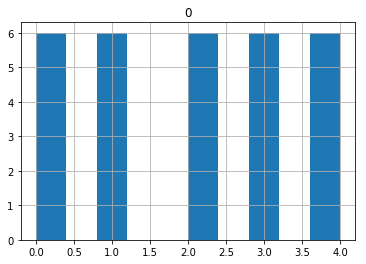

In [55]:
print(np.histogram(y_valid))
y_valid.hist(), len(y_valid)


In [106]:
# Print the metrics
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def print_score(m, detail=False):
    test_preds = m.predict(X_valid)
    train_preds = m.predict(X_train)
    res = [m.score(X_train, y_train), metrics.accuracy_score(test_preds, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print("scores:",res)   
    if detail:
        print("train confusion matrix: \n", confusion_matrix(y_train, train_preds))
        print("test confusion matrix:\n", confusion_matrix(y_valid, test_preds))
        print("train report:\n",classification_report(y_train, train_preds))
        print("test report:\n",classification_report(y_valid, test_preds))

    
import IPython, graphviz, re
from sklearn.tree import export_graphviz
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
    

In [43]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
n_valid = 20  # same as Kaggle's test set size
n_trn = len(df_x)-n_valid
raw_train, raw_valid = split_vals(df_x, n_trn)
X_train, X_valid = split_vals(df_x, n_trn)
y_train, y_valid = split_vals(df_y, n_trn)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [59]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier

In [192]:
# Train the first random forest model with one tree
clf = RandomForestClassifier(n_jobs=-1, max_depth=3, n_estimators =1,bootstrap=False#, oob_score=True
                             ,random_state=None)
%time clf.fit(X_train, y_train)
clf

CPU times: user 11.8 ms, sys: 17.8 ms, total: 29.6 ms
Wall time: 123 ms


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [193]:
%time print_score(clf)
# Baseline model 

scores: [0.8142857142857143, 0.8333333333333334]
CPU times: user 6.11 ms, sys: 3.09 ms, total: 9.2 ms
Wall time: 7.7 ms


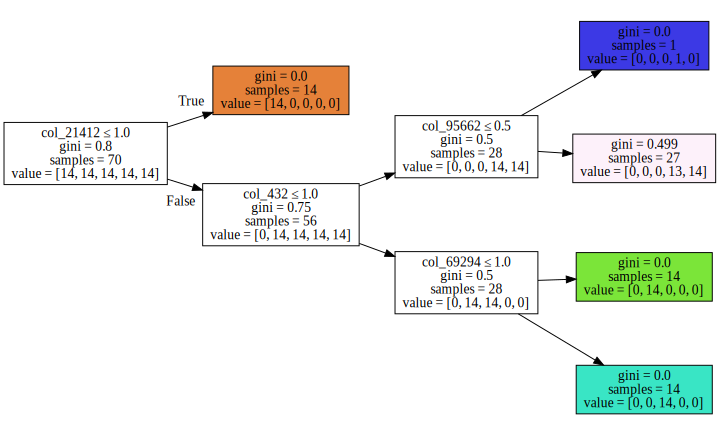

In [194]:
draw_tree(clf.estimators_[0],X_train,precision=3)
# From the tree below which is a very basic tree, certain columns are more important than others. 
# From the tree below col_42421 is best criteria and sems ot be important predictor for the eye color.

In [84]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [97]:
# Now I Increase the number of trees to test the improvement in the validation score based on the training
m=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [5,10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'min_samples_leaf' : [3,5,7,9,11],
    'criterion' :['gini', 'entropy']
}

In [191]:
CV_rfc = GridSearchCV(estimator=m, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [99]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'n_estimators': 10}

In [104]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 10, max_depth=6, min_samples_leaf= 3, criterion='gini')
rfc1.fit(X_train, y_train)
rfc1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [107]:
print_score(rfc1, False)
# From this score I notice that the model is overfitting the training data. 
# Since the validation set error is 0.266 and train score close to 1
# And not genralizing well.

scores: [0.8571428571428571, 0.3]


In [108]:
# I will train a model with different percentages of max features resulting in a better model
for n in [0.1,0.2,0.3,0.4,0.5]:
    clf = RandomForestClassifier(n_jobs=-1,  n_estimators =10, oob_score=True, max_features = n, min_samples_leaf=3
                                 ,random_state=None)
    clf.fit(X_train, y_train)
    print(n)
    print_score(clf)
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.1
scores: [1.0, 0.8, 0.6857142857142857]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.2
scores: [1.0, 0.9666666666666667, 0.6571428571428571]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.3
scores: [1.0, 1.0, 0.8857142857142857]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.4
scores: [1.0, 1.0, 0.9285714285714286]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.5
scores: [1.0, 1.0, 1.0]


In [113]:
# Final classifier with max_features less than 50%
clf = RandomForestClassifier(n_jobs=-1,  n_estimators =10, oob_score=True, max_features = 0.17, min_samples_leaf=3
                                 ,random_state=None)
clf.fit(X_train, y_train)
clf

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.17, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [115]:
print_score(clf, False)

scores: [1.0, 1.0, 0.8285714285714286]


In [116]:
clf.final = RandomForestClassifier(n_jobs=-1,  n_estimators =10, oob_score=True, max_features = 0.17, min_samples_leaf=3
                                 ,random_state=None)
clf.final.fit(df_raw, target_y)
clf.final

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.17, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [119]:
res = [clf.final.score(df_raw, target_y)]
if hasattr(clf.final, 'oob_score_'): res.append(clf.final.oob_score_)
print("scores:",res)   

scores: [1.0, 0.87]


In [125]:
# Method to get feature importance
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

In [122]:
fi = rf_feat_importance(clf.final, df_raw)
fi[:5]

,cols,imp
2,col_2,0.128925
76,col_76,0.115328
69294,col_69294,0.114219
432,col_432,0.113233
21412,col_21412,0.097372


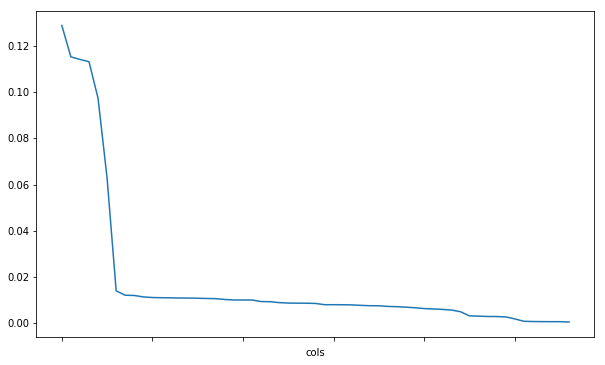

In [127]:
f1 = fi[fi.imp>0]
f1.plot('cols', 'imp', figsize=(10,6), legend=False);

57


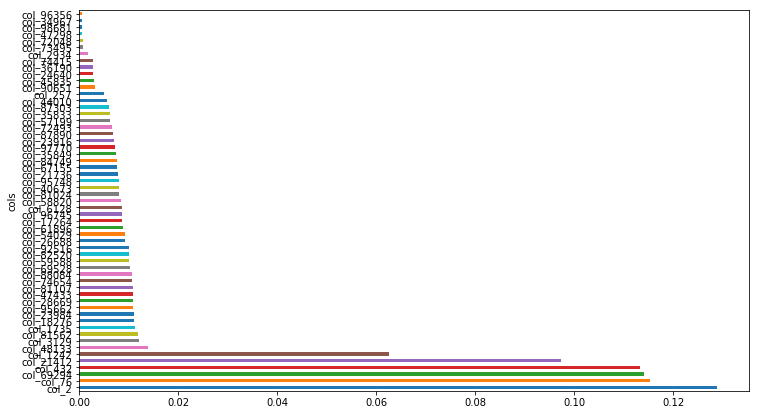

In [129]:
print(len(f1))
plot_fi(f1[:100]);

44


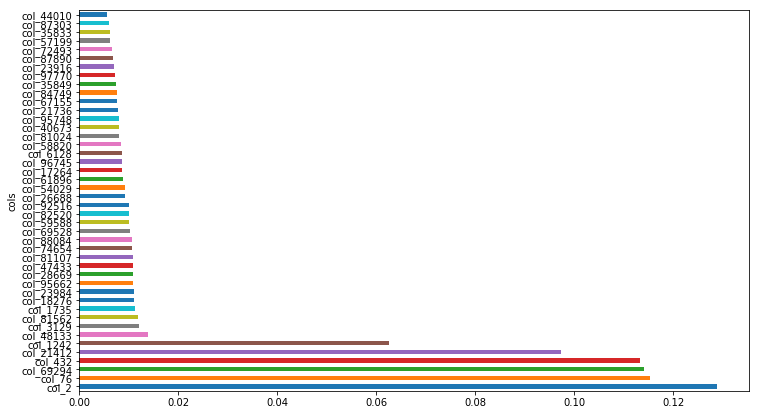

In [130]:
f2 = fi[fi.imp>0.005];print(len(f2))
plot_fi(f2[:100]);

In [131]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

44

In [133]:
df_keep = df_raw[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [145]:
m = RandomForestClassifier(n_jobs=-1,  n_estimators =10, oob_score=True, max_features = 0.4, min_samples_leaf=3
                                 ,random_state=None)
m.fit(X_train, y_train)
m

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [146]:
print_score(m, False)

scores: [1.0, 1.0, 0.9714285714285714]


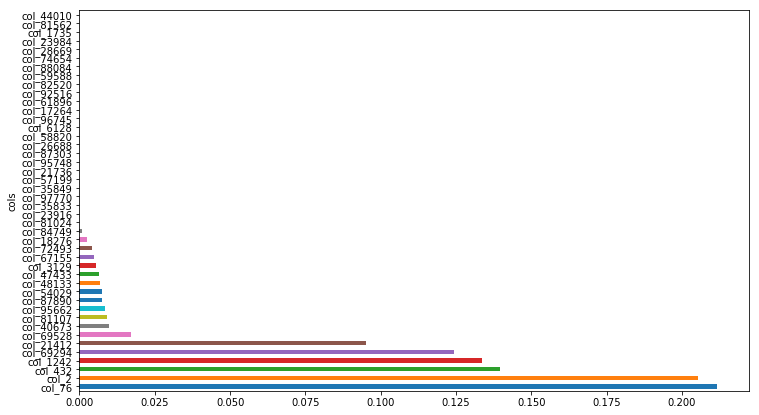

In [147]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [167]:
fi_1 = fi[fi.imp > 0.005]; len(fi_1)

15

In [168]:
to_keep = fi_1.cols

In [169]:
df_keep = df_raw[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [170]:

clf = RandomForestClassifier(n_jobs=-1,  n_estimators =10, oob_score=True, max_features = 0.4, min_samples_leaf=3
                                 ,random_state=None)
clf.fit(X_train, y_train)
clf

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [171]:
print_score(clf, True)

scores: [1.0, 1.0, 1.0]
train confusion matrix: 
 [[14  0  0  0  0]
 [ 0 14  0  0  0]
 [ 0  0 14  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 14]]
test confusion matrix:
 [[6 0 0 0 0]
 [0 6 0 0 0]
 [0 0 6 0 0]
 [0 0 0 6 0]
 [0 0 0 0 6]]
train report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        14
         1.0       1.00      1.00      1.00        14
         2.0       1.00      1.00      1.00        14
         3.0       1.00      1.00      1.00        14
         4.0       1.00      1.00      1.00        14

   micro avg       1.00      1.00      1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

test report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00 

In [204]:
#Getting the top 15 predictors columns
lst = fi_1['cols']
t1 = [int(l[4:]) for l in lst]
# t1

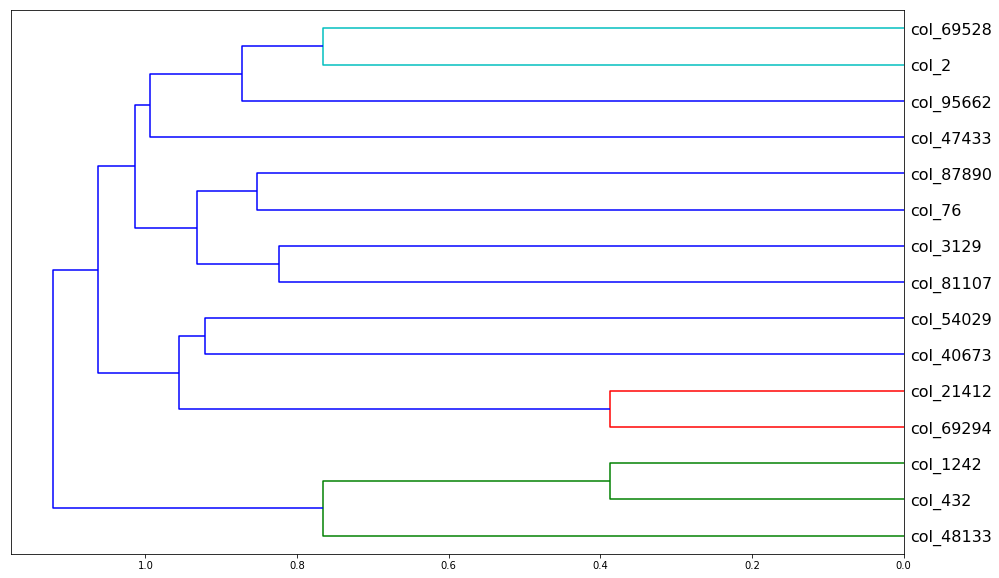

In [173]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [175]:
from  treeinterpreter import treeinterpreter as ti

In [176]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)
df_train.head()

,col_76,col_2,col_432,col_1242,col_69294,col_21412,col_69528,col_40673,col_81107,col_95662,col_87890,col_54029,col_48133,col_47433,col_3129
0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
3,0.0,2.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,1.0
4,2.0,2.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [177]:
row = X_valid.values[None,0]; row

array([[2., 2., 2., 2., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [182]:
clf.predict_proba(row)
# prediction, bias, contributions = ti.predict(clf, row)

array([[1., 0., 0., 0., 0.]])

In [185]:
prediction, bias, contributions = ti.predict(clf, row)

print("Prediction", prediction)
print("Bias (trainset prior)", bias)
print("Feature contributions:")
for c, feature in zip(contributions[0], 
                             df_keep.columns):
    print(feature, c)


Prediction [[1. 0. 0. 0. 0.]]
Bias (trainset prior) [[0.19428571 0.21714286 0.18857143 0.19142857 0.20857143]]
Feature contributions:
col_76 [ 0.01392857  0.01607143 -0.02       -0.02285714  0.01285714]
col_2 [ 0.19643343 -0.21930728 -0.05857143  0.03628904  0.04515623]
col_432 [ 0.07921189  0.0215873   0.01753968 -0.06255814 -0.05578073]
col_1242 [ 0.01392857  0.01607143  0.          0.         -0.03      ]
col_69294 [ 0.100594    0.05565649 -0.04753968 -0.04724739 -0.06146341]
col_21412 [ 0.37582418 -0.08142857 -0.08       -0.09505495 -0.11934066]
col_69528 [0. 0. 0. 0. 0.]
col_40673 [0. 0. 0. 0. 0.]
col_81107 [0. 0. 0. 0. 0.]
col_95662 [ 0.02579365 -0.02579365  0.          0.          0.        ]
col_87890 [0. 0. 0. 0. 0.]
col_54029 [0. 0. 0. 0. 0.]
col_48133 [0. 0. 0. 0. 0.]
col_47433 [0. 0. 0. 0. 0.]
col_3129 [0. 0. 0. 0. 0.]


In [187]:
prediction, bias, contributions = ti.predict(clf, row)

In [188]:
prediction[0], bias[0]

(array([1., 0., 0., 0., 0.]),
 array([0.19428571, 0.21714286, 0.18857143, 0.19142857, 0.20857143]))

In [189]:
idxs = np.argsort(contributions[0])

In [190]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[(['col_1242', 'col_432', 'col_69294', 'col_76', 'col_2'],
  array([2., 2., 0., 2., 2.]),
  array([[ 0.01392857,  0.01607143,  0.        ,  0.        , -0.03      ],
         [ 0.07921189,  0.0215873 ,  0.01753968, -0.06255814, -0.05578073],
         [ 0.100594  ,  0.05565649, -0.04753968, -0.04724739, -0.06146341],
         [ 0.01392857,  0.01607143, -0.02      , -0.02285714,  0.01285714],
         [ 0.19643343, -0.21930728, -0.05857143,  0.03628904,  0.04515623]])),
 (['col_2', 'col_432', 'col_1242', 'col_69294', 'col_76'],
  array([2., 2., 2., 0., 2.]),
  array([[ 0.19643343, -0.21930728, -0.05857143,  0.03628904,  0.04515623],
         [ 0.07921189,  0.0215873 ,  0.01753968, -0.06255814, -0.05578073],
         [ 0.01392857,  0.01607143,  0.        ,  0.        , -0.03      ],
         [ 0.100594  ,  0.05565649, -0.04753968, -0.04724739, -0.06146341],
         [ 0.01392857,  0.01607143, -0.02      , -0.02285714,  0.01285714]])),
 (['col_1242', 'col_69294', 'col_432', 'col_2', 'col_7